In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

if tf.test.gpu_device_name() == '':
    print('You do not have GPU access.')
    print('Did you change your runtime ?')
    print('If the runtime setting is correct then Google did not allocate a GPU for your session')
    print('Expect slow performance. To access GPU try reconnecting later')

else:
    print('You have GPU access')
    !nvidia-smi

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

# print the tensorflow version
print('Tensorflow version is ' + str(tf.__version__))


def scale_fn(x):
    # return 1.0 # Triangular Scaling Method
    return 1 / (2.0 ** (x - 1))  # Triangular2 Scaling method


# GRAD-CAM
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * 255
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

E0000 00:00:1749475136.751154      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749475136.804509      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


You have GPU access
Mon Jun  9 13:19:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             27W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

I0000 00:00:1749475151.160957      19 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749475151.161693      19 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Tensorflow version is 2.18.0


In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("HF_TOKEN")
# secret_value_1 = user_secrets.get_secret("WANDB_API_KEY")
# import wandb
# wandb.login(key=secret_value_1)

# from google.colab import drive
# drive.mount('/content/drive')
# !pip install --upgrade datasets
# from google.colab import userdata
# userdata.get('HF_TOKEN')
# userdata.get('WANDB_API_KEY')
# wandb.login(key=userdata.get('WANDB_API_KEY'))

In [ ]:
from pathlib import Path
import datetime
import os

import numpy as np
import wandb
from wandb.integration.keras import WandbMetricsLogger
import keras
from keras.applications import ResNet50V2
import matplotlib.pyplot as plt

run = wandb.init(project='myoquant-sdh',
                 config={
                     "BATCH_SIZE": 32,
                     "CLASS_WEIGHTS": True,
                     "EARLY_STOPPING_PATIENCE": 10,
                     "EPOCH": 1000,
                     "EPOCH_OPTI_LR": 100,
                     "LOSS": "SparseCategoricalCrossentropy",
                     "LR_PATIENCE": 5,
                     "LR_PLATEAU_RATIO": 0.2,
                     "MAX_LR": 0.00001,
                     "METRIC": "accuracy",
                     "MIN_LR": 1e-7,
                     "MODEL_NAME": "SDH16K_wandb",
                     "OPTIMIZER": "adam",
                     "OPTI_START_LR": 1e-7,
                     "RELOAD_MODEL": False,
                     "SUB_FOLDERS": {0: "control", 1: "sick"},
                     "UPLOAD_LOGS": True,
                 }
                 )

config = wandb.config
keras.utils.set_random_seed(42)
MODEL_PATH = os.path.join("results", datetime.datetime.now().strftime(config.MODEL_NAME + "_%Y%m%d-%H%M%S"))
Path(MODEL_PATH).mkdir(parents=True, exist_ok=True)
logdir = os.path.join("runs", datetime.datetime.now().strftime(config.MODEL_NAME + "_%Y%m%d-%H%M%S"))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir)

In [4]:
import datasets


def preprocess_image(example):
    image = np.array(example['image'].resize((256, 256), reducing_gap=3.0), dtype=np.float32)
    return {'image': image, 'label': example['label']}


myoquant_sdh_16k = datasets.load_dataset("corentinm7/MyoQuant-SDH-Data")


# Convert to tf.data.Dataset directly
def create_tf_dataset(dataset_split):
    ds = tf.data.Dataset.from_generator(
        lambda: (preprocess_image(x) for x in dataset_split),
        output_signature={
            'image': tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            'label': tf.TensorSpec(shape=(), dtype=tf.int64)
        }
    )
    return ds


# Create datasets with proper prefetch and caching
train_dataset = create_tf_dataset(myoquant_sdh_16k['train']).cache()
val_dataset = create_tf_dataset(myoquant_sdh_16k['validation']).cache()
test_dataset = create_tf_dataset(myoquant_sdh_16k['test']).cache()

# Apply transformations
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (train_dataset
                 .shuffle(10000)
                 .map(lambda x: (x['image'], x['label']), num_parallel_calls=AUTOTUNE)
                 .prefetch(AUTOTUNE))

val_dataset = (val_dataset
               .map(lambda x: (x['image'], x['label']), num_parallel_calls=AUTOTUNE)
               .prefetch(AUTOTUNE))

test_dataset = (test_dataset
                .map(lambda x: (x['image'], x['label']), num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))

data_augmentation = keras.Sequential([
    keras.layers.RandomBrightness(factor=0.2),
    keras.layers.RandomContrast(factor=0.2),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.3, fill_mode="constant"),
    keras.layers.RandomZoom(.2, .2, fill_mode="constant"),
    keras.layers.RandomTranslation(0.2, .2, fill_mode="constant"),
])

train_dataset = train_dataset.batch(config.BATCH_SIZE).prefetch(1)
val_dataset = val_dataset.batch(config.BATCH_SIZE).prefetch(1)
test_dataset = test_dataset.batch(config.BATCH_SIZE).prefetch(1)

README.md:   0%|          | 0.00/8.46k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/341M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/339M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/113M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12085 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1344 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3358 [00:00<?, ? examples/s]

I0000 00:00:1749475173.451682      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749475173.451930      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


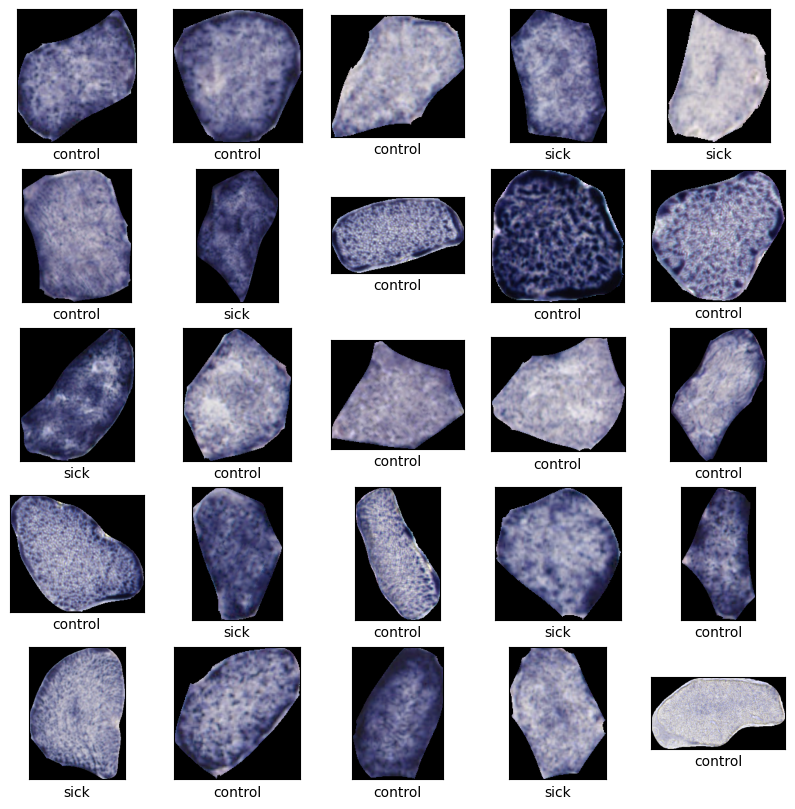

In [5]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
train_labels = [item['label'] for item in myoquant_sdh_16k['train']]

if config.CLASS_WEIGHTS:
    class_weights_numpy = np.unique(train_labels, return_counts=True)
    n_train = len(myoquant_sdh_16k['train'])
    class_weights = dict()
    for index, folder in enumerate(config.SUB_FOLDERS):
        class_weights[class_weights_numpy[0][index]] = (1 / class_weights_numpy[1][index]) * (n_train / 2.0)
else:
    class_weights = None

    print(class_weights)

plt.figure(figsize=(10, 10))
counter = 0
for i in np.random.choice(range(len(myoquant_sdh_16k['train'])), 25):
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(myoquant_sdh_16k['train'][int(i)]["image"])
    plt.xlabel(list(config.SUB_FOLDERS.values())[myoquant_sdh_16k['train'][int(i)]["label"]])
    counter += 1
plt.show()

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomBrightness(factor=0.2, input_shape=(None, None, 3)),
    keras.layers.RandomContrast(factor=0.2),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.3, fill_mode="constant"),
    keras.layers.RandomZoom(.2, .2, fill_mode="constant"),
    keras.layers.RandomTranslation(0.2, .2, fill_mode="constant"),
    keras.layers.Resizing(256, 256, interpolation="bilinear", crop_to_aspect_ratio=True, input_shape=(None, None, 3)),
    keras.layers.Rescaling(scale=1. / 127.5, offset=-1),  # For [-1, 1] scaling
])

# My ResNet50V2
model = keras.models.Sequential()
model.add(data_augmentation)
model.add(
    ResNet50V2(
        include_top=False,
        input_shape=(256, 256, 3),
        pooling="avg",
    )
)
model.add(keras.layers.Dense(len(config.SUB_FOLDERS), activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,568,898 (89.91 MB)

 Trainable params: 23,523,458 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [7]:
# Find min max LR
"""
def scheduler(epoch, lr):
    return lr*exp(log(pow(10,8))/EPOCH_OPTI_LR)

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=OPTI_START_LR),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

lr_cb = keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_images, train_labels, epochs=EPOCH_OPTI_LR, batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels), shuffle=True, class_weight=class_weights,
                    callbacks=[lr_cb, tensorboard_cb])

loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate_range = [OPTI_START_LR]
for epoch in range(EPOCH_OPTI_LR-1):
  learning_rate_range.append(learning_rate_range[epoch] * exp(log(pow(10,8))/EPOCH_OPTI_LR))

plt.figure(figsize=(16, 8))

plt.subplot(1, 1, 1)
plt.plot(learning_rate_range, loss, label='Training Loss')
plt.plot(learning_rate_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xscale('log')
plt.savefig(os.path.join(MODEL_PATH, "curve_findLR.png"), dpi=300)
plt.show()
"""

'\ndef scheduler(epoch, lr):\n    return lr*exp(log(pow(10,8))/EPOCH_OPTI_LR)\n\nmodel.compile(optimizer=keras.optimizers.Nadam(learning_rate=OPTI_START_LR),\n              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=[\'accuracy\'])\n\nlr_cb = keras.callbacks.LearningRateScheduler(scheduler)\nhistory = model.fit(train_images, train_labels, epochs=EPOCH_OPTI_LR, batch_size=BATCH_SIZE,\n                    validation_data=(val_images, val_labels), shuffle=True, class_weight=class_weights,\n                    callbacks=[lr_cb, tensorboard_cb])\n\nloss = history.history[\'loss\']\nval_loss = history.history[\'val_loss\']\n\nlearning_rate_range = [OPTI_START_LR]\nfor epoch in range(EPOCH_OPTI_LR-1):\n  learning_rate_range.append(learning_rate_range[epoch] * exp(log(pow(10,8))/EPOCH_OPTI_LR))\n\nplt.figure(figsize=(16, 8))\n\nplt.subplot(1, 1, 1)\nplt.plot(learning_rate_range, loss, label=\'Training Loss\')\nplt.plot(learning_rate_range, val_los

In [8]:
import pickle

# steps_per_epoch = len(myoquant_sdh_16k['train']) // config.BATCH_SIZE  # Batch size is 32

# Triangular 1Cycle Scheduler and Cosine Scheduler
# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=MIN_LR,
#     maximal_learning_rate=MAX_LR,
#     scale_fn=scale_fn,
#     step_size= 8 * steps_per_epoch
# )
# cosine_decay = keras.optimizers.schedules.CosineDecayRestarts(
#    TRAIN_LR, 10 * steps_per_epoch, t_mul=1.0, m_mul=1.0, alpha=0.005)

# if config.RELOAD_MODEL:
#   print(config.MODEL_NAME, " reloaded as starting point!")
#   model = keras.models.load_model(os.path.join(MODEL_PATH, "model.keras"))


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=config.LR_PLATEAU_RATIO,
                                              patience=config.LR_PATIENCE, min_lr=config.MIN_LR)

checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH, "model.keras"), save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=config.EARLY_STOPPING_PATIENCE, restore_best_weights=True)
wandb_metrics = WandbMetricsLogger(log_freq="epoch")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.MAX_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[config.METRIC]
)

history = model.fit(train_dataset, epochs=config.EPOCH, batch_size=config.BATCH_SIZE,
                    validation_data=val_dataset, shuffle=True, class_weight=class_weights,
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb, tensorboard_cb, wandb_metrics])

art = wandb.Artifact("myoquant-sdh-classifier", type="model")
art.add_file(os.path.join(MODEL_PATH, "model.keras"))
wandb.log_artifact(art)
wandb.finish()

model = keras.models.load_model(os.path.join(MODEL_PATH, "model.keras"))
with open(os.path.join(MODEL_PATH, "history.pickle"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# model.export(os.path.join(MODEL_PATH, "tf_saved_format"), format="tf_saved_model", input_signature=[keras.InputSpec(shape=(None, None, None, 3), dtype="float32")])

Epoch 1/1000


I0000 00:00:1749475259.752341     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


    378/Unknown 289s 552ms/step - accuracy: 0.6320 - loss: 0.5767

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


378/378 ━━━━━━━━━━━━━━━━━━━━ 299s 580ms/step - accuracy: 0.6323 - loss: 0.5763 - val_accuracy: 0.8906 - val_loss: 0.2854 - learning_rate: 1.0000e-05
Epoch 2/1000
378/378 ━━━━━━━━━━━━━━━━━━━━ 217s 575ms/step - accuracy: 0.9020 - loss: 0.2758 - val_accuracy: 0.9263 - val_loss: 0.1994 - learning_rate: 1.0000e-05
Epoch 3/1000
378/378 ━━━━━━━━━━━━━━━━━━━━ 216s 571ms/step - accuracy: 0.9104 - loss: 0.2451 - val_accuracy: 0.9167 - val_loss: 0.2129 - learning_rate: 1.0000e-05
Epoch 4/1000
378/378 ━━━━━━━━━━━━━━━━━━━━ 216s 571ms/step - accuracy: 0.9122 - loss: 0.2252 - val_accuracy: 0.9196 - val_loss: 0.2117 - learning_rate: 1.0000e-05
Epoch 5/1000
378/378 ━━━━━━━━━━━━━━━━━━━━ 218s 576ms/step - accuracy: 0.9142 - loss: 0.2016 - val_accuracy: 0.9278 - val_loss: 0.1898 - learning_rate: 1.0000e-05
Epoch 6/1000
378/378 ━━━━━━━━━━━━━━━━━━━━ 217s 574ms/step - accuracy: 0.9147 - loss: 0.2044 - val_accuracy: 0.9323 - val_loss: 0.1868 - learning_rate: 1.0000e-05
Epoch 7/1000
378/378 ━━━━━━━━━━━━━━━━━━━━

wandb: uploading artifact myoquant-sdh-classifier
wandb: 
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch/accuracy ▁▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
wandb:         epoch/epoch ▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
wandb: epoch/learning_rate ████████████████████▂▂▂▂▂▁
wandb:          epoch/loss █▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:  epoch/val_accuracy ▁▆▄▅▆▇▆▆▆▆▆▆▅▅██▇▇▇▆▆▇▇▇▇▇
wandb:      epoch/val_loss █▃▄▄▃▃▃▃▂▂▃▂▄▃▁▁▂▂▂▂▂▂▁▂▂▂
wandb: 
wandb: Run summary:
wandb:      epoch/accuracy 0.94497
wandb:         epoch/epoch 25
wandb: epoch/learning_rate 0.0
wandb:          epoch/loss 0.1294
wandb:  epoch/val_accuracy 0.9375
wandb:      epoch/val_loss 0.16438
wandb: 
wandb: 🚀 View run eager-pine-49 at: https://wandb.ai/lambda-science/myoquant-sdh/runs/tage948z
wandb: ⭐️ View project at: https://wandb.ai/lambda-science/myoquant-sdh
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 0 other file(s)
wandb: Find logs

In [9]:
# import keras
# import os
# full_model = keras.models.load_model(os.path.join(MODEL_PATH, "model.keras"))
# # Extract the ResNet and classifier part from the trained model
# # The original model was: [augmentation] → [ResNet] → [Dense]
# resnet = full_model.layers[1]  # ResNet50V2
# dense = full_model.layers[2]  # Final Dense layer
#
# # Reconstruct the new model without augmentation
# inputs = keras.Input(shape=(None, None, 3), name="input")
# # Safe preprocessing that may be exportable
# x = keras.layers.Resizing(256, 256, interpolation="bilinear")(inputs)
# x = keras.layers.Rescaling(1./127.5, offset=-1)(x)
# x = resnet(x)
# outputs = dense(x)
# exportable_model = keras.Model(inputs, outputs)
# exportable_model.export(os.path.join(MODEL_PATH, "model.onnx"), format="onnx", input_signature=[keras.InputSpec(shape=(None, None, None, 3), dtype="float32")])

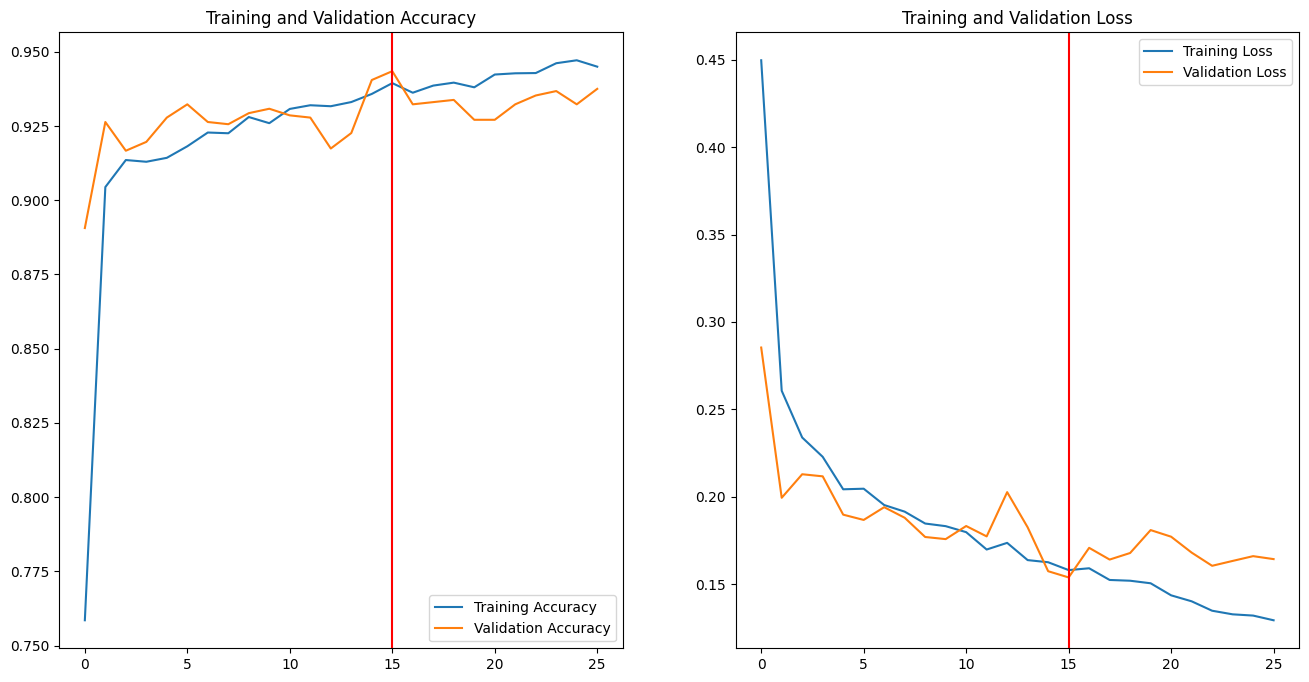

In [10]:
# Acc and Loss Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=len(acc) - config.EARLY_STOPPING_PATIENCE - 1, color="red")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=len(acc) - config.EARLY_STOPPING_PATIENCE - 1, color="red")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(os.path.join(MODEL_PATH, "training_curve.png"), dpi=300)
plt.show()

In [11]:
# Test Evaluation
test_labels = [item['label'] for item in myoquant_sdh_16k['test']]

from sklearn.metrics import balanced_accuracy_score

model = keras.models.load_model(os.path.join(MODEL_PATH, "model.keras"))

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("Test data results: ")
print(test_acc)

test_proba = model.predict(test_dataset)
test_classes = test_proba.argmax(axis=-1)
print("Test data results: ")
print(balanced_accuracy_score(test_labels, test_classes))

105/105 - 22s - 207ms/step - accuracy: 0.9276 - loss: 0.1678
Test data results: 
0.9276354908943176
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step
Test data results: 
0.9128566397981572


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

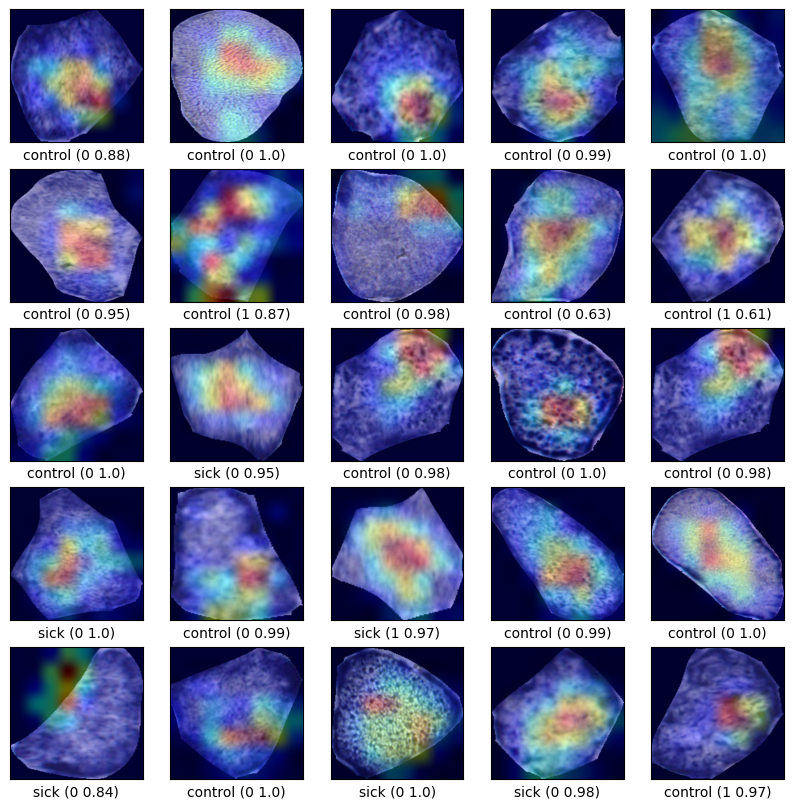

In [12]:
# Generate class activation heatmap
model = keras.models.load_model(os.path.join(MODEL_PATH, "model.keras"))
counter = 0
plt.figure(figsize=(10, 10))

for i in np.random.choice(range(len(myoquant_sdh_16k['test'])), 25):
    img_array = np.empty((1, 256, 256, 3))
    # Convert TIFF image to numpy array first
    img = np.array(myoquant_sdh_16k['train'][int(i)]["image"].resize((256, 256), reducing_gap=3.0))
    img_array[0] = img / 255.0  # Now we can safely normalize
    predicted_class = model.predict(img_array * 255).argmax()
    predicted_proba = round(np.amax(model.predict(img_array * 255)), 2)
    heatmap = make_gradcam_heatmap(img_array, model.get_layer("resnet50v2"), "conv5_block3_3_conv")
    plt.subplot(5, 5, counter + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    grad_cam_img = save_and_display_gradcam(img_array[0], heatmap)
    plt.imshow(grad_cam_img)
    xlabel = config.SUB_FOLDERS[test_labels[int(i)]] + " (" + str(predicted_class) + " " + str(predicted_proba) + ")"
    plt.xlabel(xlabel)
    counter += 1
plt.show()